In [97]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import visualkeras

In [62]:
BATCH_SIZE = 64
IMAGE_SIZE = 150
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "new_train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "new_test",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE  
)

Found 3125 files belonging to 21 classes.
Found 1711 files belonging to 21 classes.


In [83]:
class_names = train_dataset.class_names
class_names

['Nail Fungus and other Nail Disease',
 'acne_rosacea',
 'actinic_keratosis',
 'atopic_dermatitis',
 'bacteria_infection',
 'basal_cell',
 'biting_insect',
 'bullous',
 'dermatofibroma',
 'eczema',
 'hemangioma',
 'herpes',
 'keratoses',
 'lichen_planus',
 'lupus',
 'melanoma',
 'nevi',
 'psoriasis',
 'tinea',
 'vasculitis',
 'warts']

In [72]:
import os

# list = os.listdir('new_train') # dir is your directory path
# cpt = sum([print(len(files)) for r, d, files in os.walk("new_train")])
num_files = []
[num_files.append((len(files))) for r, d, files in os.walk("new_train")]
(num_files.pop(0))
arr = np.array(num_files)

arr = 1/(arr/sum(arr))

class_weight = {}
for i in range(len(arr)):
    class_weight[i] = arr[i]



[73, 66, 49, 58, 174, 52, 40, 99, 135, 75, 110, 310, 83, 28, 108, 854, 290, 158, 145, 72, 149]


{0: 42.849315068493155,
 1: 47.3939393939394,
 2: 63.83673469387755,
 3: 53.93103448275862,
 4: 17.977011494252874,
 5: 60.153846153846146,
 6: 78.2,
 7: 31.59595959595959,
 8: 23.17037037037037,
 9: 41.70666666666667,
 10: 28.436363636363634,
 11: 10.09032258064516,
 12: 37.68674698795181,
 13: 111.71428571428572,
 14: 28.962962962962965,
 15: 3.6627634660421546,
 16: 10.786206896551723,
 17: 19.79746835443038,
 18: 21.572413793103447,
 19: 43.44444444444444,
 20: 20.993288590604028}

In [40]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.2,shuffle = True,shuffle_size = 10000):
  assert(train_split+val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  return train_ds, val_ds


In [41]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale = tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [44]:
data_augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [45]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
model = models.Sequential([
                           resize_and_rescale,
                           layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3) ),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)), 
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)),    
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),    
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(21, activation='softmax')
])
model.build(input_shape = (BATCH_SIZE,128,128,3))

In [98]:
visualkeras.layered_view(model).show()

In [47]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (64, 150, 150, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 148, 148, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 74, 74, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 72, 72, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 36, 36, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 34, 34, 128)        

In [48]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [73]:
EPOCHS = 100
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    class_weight = class_weight
) 

Epoch 1/100
39/39 [==============================] - 10s 231ms/step - loss: 77.3687 - accuracy: 0.3590 - val_loss: 2.0976 - val_accuracy: 0.3993
Epoch 2/100
39/39 [==============================] - 9s 223ms/step - loss: 63.4134 - accuracy: 0.3726 - val_loss: 1.9625 - val_accuracy: 0.4132
Epoch 3/100
39/39 [==============================] - 9s 222ms/step - loss: 57.5922 - accuracy: 0.4032 - val_loss: 1.9930 - val_accuracy: 0.4219
Epoch 4/100
39/39 [==============================] - 9s 227ms/step - loss: 55.0028 - accuracy: 0.4193 - val_loss: 1.8543 - val_accuracy: 0.4427
Epoch 5/100
39/39 [==============================] - 9s 222ms/step - loss: 52.0392 - accuracy: 0.4499 - val_loss: 1.7327 - val_accuracy: 0.4809
Epoch 6/100
39/39 [==============================] - 9s 225ms/step - loss: 49.0566 - accuracy: 0.4612 - val_loss: 1.6201 - val_accuracy: 0.5243
Epoch 7/100
39/39 [==============================] - 9s 223ms/step - loss: 46.1045 - accuracy: 0.4829 - val_loss: 1.8218 - val_accuracy

39/39 [==============================] - 9s 226ms/step - loss: 12.9107 - accuracy: 0.8213 - val_loss: 1.0196 - val_accuracy: 0.7622
Epoch 58/100
39/39 [==============================] - 9s 226ms/step - loss: 10.7917 - accuracy: 0.8326 - val_loss: 0.8708 - val_accuracy: 0.7795
Epoch 59/100
39/39 [==============================] - 9s 225ms/step - loss: 10.8984 - accuracy: 0.8447 - val_loss: 1.0955 - val_accuracy: 0.7483
Epoch 60/100
39/39 [==============================] - 9s 221ms/step - loss: 11.6862 - accuracy: 0.8278 - val_loss: 1.0098 - val_accuracy: 0.7778
Epoch 61/100
39/39 [==============================] - 9s 224ms/step - loss: 10.5077 - accuracy: 0.8479 - val_loss: 1.3311 - val_accuracy: 0.7274
Epoch 62/100
39/39 [==============================] - 9s 227ms/step - loss: 13.4347 - accuracy: 0.8109 - val_loss: 0.9752 - val_accuracy: 0.7604
Epoch 63/100
39/39 [==============================] - 9s 228ms/step - loss: 9.3723 - accuracy: 0.8487 - val_loss: 0.8214 - val_accuracy: 0.7795

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

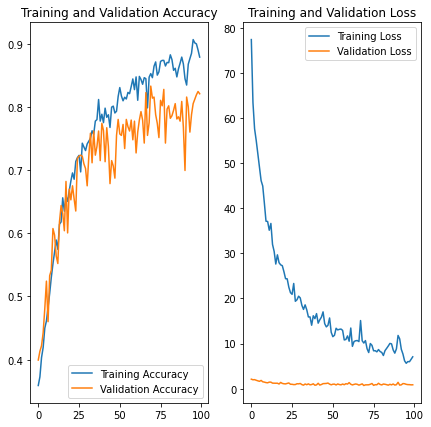

In [90]:
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [82]:
model.save("./model_new/build")

INFO:tensorflow:Assets written to: ./model_new/build\assets


INFO:tensorflow:Assets written to: ./model_new/build\assets


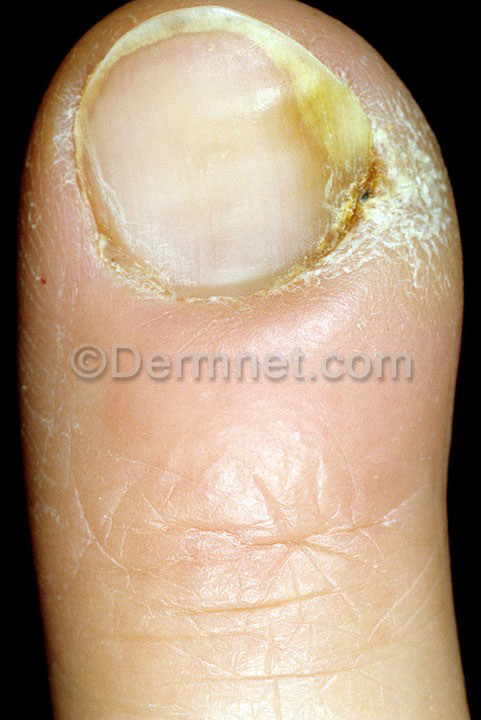

1/1 [==============================] - 0s 68ms/step


In [109]:
import tensorflow as tf
from PIL import Image
import numpy as np


def predict(model, img):  # model
    img = Image.open(img)
    img_array = tf.keras.preprocessing.image.img_to_array(np.array(img))
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    top_k_values, top_k_indices = tf.math.top_k(predictions, k=5)

    predicted_class = [top_k_indices.numpy()[0][j] for j in range(5)]

    return predicted_class  # 다섯개 확률높은 결과값 뽑기 , confidence


model = tf.keras.models.load_model('model_new/build')   #model 경로 로드하기
img = "nail.jpg"
image = Image.open(img)
display(image)

predicted_class = predict(model, img) # predicted_class에 5개 top indices 배열로 저장

class_names = ['Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'acne_rosacea',
 'actinic_keratosis',
 'atopic_dermatitis',
 'bacteria_infection',
 'basal_cell',
 'biting_insect',
 'bullous',
 'dermatofibroma',
 'eczema',
 'hemangioma',
 'herpes',
 'keratoses',
 'lichen_planus',
 'lupus',
 'psoriasis',
 'tinea',
 'vasculitis',
 'warts']




In [110]:
print(predicted_class)
for i in range(5):
    
    print(class_names[predicted_class[i]])

[1, 13, 10, 7, 16]
Nail Fungus and other Nail Disease
keratoses
eczema
biting_insect
psoriasis
